In [ ]:
!pip install vaderSentiment
!pip install pandas numpy nltk matplotlib scikit-learn vaderSentiment yfinance
!pip install --user tensorflow
!pip install --user keras


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf

from tensorflow import keras
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from transformers import pipeline
from matplotlib import pyplot

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout


# Dataset (Tweets Sentiment)


In [ ]:
tweets = pd.read_csv('tweets.csv', encoding='latin1')
tweets.head()

,token,date,reply_count,like_count,retweet_count,quote_count,text,sentiment_label,sentiment_score
0,bitcoin,2022-01-01 00:00:00.000,20,207,31,3,Most people underestimate the impact #Bitcoin ...,Neutral,0.717482
1,bitcoin,2022-01-01 00:00:00.000,232,3405,286,27,#Bitcoin has started a new yearly candle https...,Neutral,0.810814
2,bitcoin,2022-01-01 00:00:00.000,2,861,12,0,@DESTROYBINARY did people forget that the amog...,Neutral,0.606978
3,bitcoin,2022-01-01 00:00:00.000,18,306,30,9,"In 2017, miners attempted to assert control ov...",Negative,0.510956
4,bitcoin,2022-01-01 00:00:00.000,35,721,35,1,Yearly Close \nMonthly Close\nDaily Close\n\nh...,Positive,0.988296


In [ ]:
#Preprocessing
tweets = tweets.drop(['token','reply_count','like_count','retweet_count', 'quote_count', 'sentiment_label','text'], axis=1)

In [ ]:
tweets.head()

,date,sentiment_score
0,2022-01-01 00:00:00.000,0.717482
1,2022-01-01 00:00:00.000,0.810814
2,2022-01-01 00:00:00.000,0.606978
3,2022-01-01 00:00:00.000,0.510956
4,2022-01-01 00:00:00.000,0.988296


In [ ]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76797 entries, 0 to 76796
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             76797 non-null  object 
 1   sentiment_score  76797 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.2+ MB


In [ ]:
tweets['date'] = pd.to_datetime(tweets['date'])

In [ ]:
tweets['DateTime'] = tweets['date'].dt.floor('h')
tweets.head()

,date,sentiment_score,DateTime
0,2022-01-01,0.717482,2022-01-01
1,2022-01-01,0.810814,2022-01-01
2,2022-01-01,0.606978,2022-01-01
3,2022-01-01,0.510956,2022-01-01
4,2022-01-01,0.988296,2022-01-01


In [ ]:
vdf = tweets.groupby(pd.Grouper(key='date',freq='H')).size().reset_index(name='tweet_vol')

In [ ]:
vdf.head(100)

,date,tweet_vol
0,2022-01-01 00:00:00,114
1,2022-01-01 01:00:00,0
2,2022-01-01 02:00:00,0
3,2022-01-01 03:00:00,0
4,2022-01-01 04:00:00,0
...,...,...
95,2022-01-04 23:00:00,0
96,2022-01-05 00:00:00,79
97,2022-01-05 01:00:00,0
98,2022-01-05 02:00:00,0


In [ ]:
vdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12889 entries, 0 to 12888
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       12889 non-null  datetime64[ns]
 1   tweet_vol  12889 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 201.5 KB


In [ ]:
vdf.index = pd.to_datetime(vdf.index)
vdf = vdf.set_index('date')

In [ ]:
vdf.head()

,tweet_vol
date,
2022-01-01 00:00:00,114
2022-01-01 01:00:00,0
2022-01-01 02:00:00,0
2022-01-01 03:00:00,0
2022-01-01 04:00:00,0


In [ ]:
tweets.index = pd.to_datetime(tweets.index)

In [ ]:
vdf['tweet_vol'] = vdf['tweet_vol'].astype(float)

In [ ]:
tweets.head()

,date,sentiment_score,DateTime
1970-01-01 00:00:00.000000000,2022-01-01,0.717482,2022-01-01
1970-01-01 00:00:00.000000001,2022-01-01,0.810814,2022-01-01
1970-01-01 00:00:00.000000002,2022-01-01,0.606978,2022-01-01
1970-01-01 00:00:00.000000003,2022-01-01,0.510956,2022-01-01
1970-01-01 00:00:00.000000004,2022-01-01,0.988296,2022-01-01


In [ ]:
df = tweets.groupby('DateTime').agg(lambda x: x.mean())

In [ ]:
df['Tweet_vol'] = vdf['tweet_vol']

In [ ]:
df = df.drop(df.index[0])
df.head()

,date,sentiment_score,Tweet_vol
DateTime,,,
2022-01-02,2022-01-02,0.724668,73.0
2022-01-03,2022-01-03,0.758271,76.0
2022-01-04,2022-01-04,0.737739,61.0
2022-01-05,2022-01-05,0.702609,79.0
2022-01-06,2022-01-06,0.702386,88.0


In [ ]:
df=df.drop(['date'],axis=1)

In [ ]:
df.tail()

,sentiment_score,Tweet_vol
DateTime,,
2023-06-18,0.737353,100.0
2023-06-19,0.725797,100.0
2023-06-20,0.715979,100.0
2023-06-21,0.718877,100.0
2023-06-22,0.720538,100.0




#Dataset (Bitcoin Historical Price)

In [ ]:
price = pd.read_csv('BTC-USD (2014-2024).csv', encoding='latin1')
price

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,3.448320e+07
1,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,3.791970e+07
2,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,3.686360e+07
3,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,2.658010e+07
4,2014-09-22,399.100006,406.915985,397.130005,402.152008,402.152008,2.412760e+07
...,...,...,...,...,...,...,...
3408,2024-01-17,43132.101563,43189.890625,42189.308594,42742.652344,42742.652344,2.085123e+10
3409,2024-01-18,42742.312500,42876.347656,40631.171875,41262.058594,41262.058594,2.521836e+10
3410,2024-01-19,41278.460938,42134.160156,40297.457031,41618.406250,41618.406250,2.575241e+10
3411,2024-01-20,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
price['Date'] = pd.to_datetime(price['Date'])
btc_data = price.set_index(pd.DatetimeIndex(price['Date']))

In [ ]:
btc_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2014-09-18,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2014-09-19,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
2014-09-20,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
2014-09-21,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0
2014-09-22,2014-09-22,399.100006,406.915985,397.130005,402.152008,402.152008,24127600.0


In [ ]:
btc_data = btc_data.drop(['Date'], axis=1)

In [ ]:
Final_df = pd.merge(df, btc_data, how='inner',left_index=True, right_index=True)

In [ ]:
Final_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 537 entries, 2022-01-02 to 2023-06-22
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sentiment_score  537 non-null    float64
 1   Tweet_vol        537 non-null    float64
 2   Open             537 non-null    float64
 3   High             537 non-null    float64
 4   Low              537 non-null    float64
 5   Close            537 non-null    float64
 6   Adj Close        537 non-null    float64
 7   Volume           537 non-null    float64
dtypes: float64(8)
memory usage: 37.8 KB


In [ ]:
def SMA(df, periods=5):
    """
    Calculating the Simple Moving Average for the past n days

    **Values must be descending**
    """
    lst = []

    for i in range(len(df)):
        if i < periods:

            # Appending NaNs for instances unable to look back on
            lst.append(np.nan)

        else:
            # Calculating the SMA
            lst.append(round(np.mean(df[i:periods+i]), 2))

    return lst

def RSI(df, periods=5):
    """
    Calculates the Relative Strength Index

    **Values must be descending**
    """

    df = df.diff()

    lst = []

    for i in range(len(df)):
        if i < periods or i==len(df)-1:

            # Appending NaNs for instances unable to look back on
            lst.append(np.nan)

        else:

            # Calculating the Relative Strength Index
            avg_gain = (sum([x for x in df[i:periods+i] if x >= 0]) / periods)
            avg_loss = (sum([abs(x) for x in df[i:periods+i] if x <= 0]) / periods)
            if avg_loss==0:
                lst.append(np.nan)
            else:
                rs = avg_gain / avg_loss

                rsi = 100 - (100 / (1 + rs))

                lst.append(round(rsi, 2))
    return lst


In [ ]:
Final_df['RSI']=RSI(Final_df['Close'])
Final_df['SMA']=SMA(Final_df['Close'])
Final_df=Final_df[5:]

In [ ]:
Final_df[Final_df['RSI']==np.nan]['RSI']=Final_df['RSI'].mean()

In [ ]:
Final_df['RSI'][-1]=Final_df['RSI'].mean()

In [ ]:
Final_df.tail()

,sentiment_score,Tweet_vol,Open,High,Low,Close,Adj Close,Volume,RSI,SMA
2023-06-18,0.737353,100.0,26510.457031,26675.925781,26325.890625,26336.212891,26336.212891,9.565695e+09,92.730000,28290.86
2023-06-19,0.725797,100.0,26335.441406,26984.611328,26312.832031,26851.029297,26851.029297,1.282699e+10,96.980000,28779.52
2023-06-20,0.715979,100.0,26841.664063,28388.968750,26668.791016,28327.488281,28327.488281,2.221186e+10,96.510000,29422.36
2023-06-21,0.718877,100.0,28311.310547,30737.330078,28283.410156,30027.296875,30027.296875,3.334676e+10,93.660000,29969.79
2023-06-22,0.720538,100.0,29995.935547,30495.998047,29679.158203,29912.281250,29912.281250,2.065316e+10,48.562288,29912.28


In [ ]:
RSI=Final_df['RSI'].mean()
for i in range(len(Final_df)):
    if np.isnan(Final_df['RSI'][i]):
        Final_df['RSI'][i]=RSI


In [ ]:
Final_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 532 entries, 2022-01-07 to 2023-06-22
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sentiment_score  532 non-null    float64
 1   Tweet_vol        532 non-null    float64
 2   Open             532 non-null    float64
 3   High             532 non-null    float64
 4   Low              532 non-null    float64
 5   Close            532 non-null    float64
 6   Adj Close        532 non-null    float64
 7   Volume           532 non-null    float64
 8   RSI              532 non-null    float64
 9   SMA              532 non-null    float64
dtypes: float64(10)
memory usage: 45.7 KB


In [ ]:
Final_df.head()

,sentiment_score,Tweet_vol,Open,High,Low,Close,Adj Close,Volume,RSI,SMA
2022-01-07,0.706142,77.0,43153.570313,43153.570313,41077.445313,41557.902344,41557.902344,8.419661e+10,42.82,41952.11
2022-01-08,0.708978,58.0,41561.464844,42228.941406,40672.277344,41733.941406,41733.941406,2.806636e+10,96.49,42430.35
2022-01-09,0.739537,73.0,41734.726563,42663.949219,41338.160156,41911.601563,41911.601563,2.129438e+10,61.42,42601.88
2022-01-10,0.738161,74.0,41910.230469,42199.484375,39796.570313,41821.261719,41821.261719,3.210423e+10,64.55,42839.50
2022-01-11,0.708726,61.0,41819.507813,43001.156250,41407.753906,42735.855469,42735.855469,2.632765e+10,66.66,43110.73


#Analysis

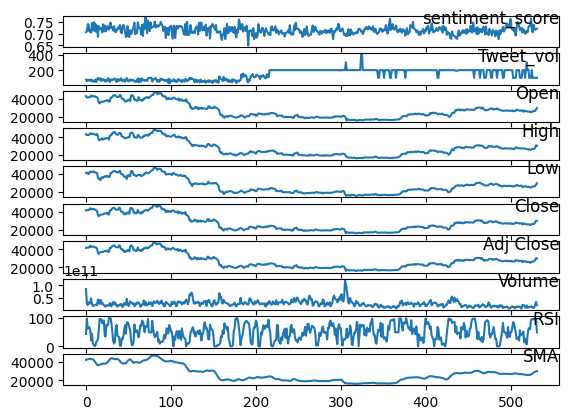

In [ ]:
values = Final_df.values
groups = [0,1,2,3,4,5,6,7,8,9]
i =1
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1,i)
    pyplot.plot(values[:,group])
    pyplot.title(Final_df.columns[group], y=.5, loc='right')
    i += 1
pyplot.show()

In [ ]:
cor = Final_df.corr()
cor

,sentiment_score,Tweet_vol,Open,High,Low,Close,Adj Close,Volume,RSI,SMA
sentiment_score,1.000000,-0.180204,0.238381,0.235368,0.253146,0.248155,0.248155,-0.212791,-0.040963,0.239370
Tweet_vol,-0.180204,1.000000,-0.660318,-0.662844,-0.655565,-0.660430,-0.660430,0.024275,-0.002096,-0.657710
Open,0.238381,-0.660318,1.000000,0.997756,0.997015,0.994386,0.994386,-0.032026,-0.134456,0.987146
High,0.235368,-0.662844,0.997756,1.000000,0.996393,0.997453,0.997453,-0.014237,-0.115363,0.990341
Low,0.253146,-0.655565,0.997015,0.996393,1.000000,0.997465,0.997465,-0.065952,-0.116966,0.990325
Close,0.248155,-0.660430,0.994386,0.997453,0.997465,1.000000,1.000000,-0.043563,-0.095671,0.993053
Adj Close,0.248155,-0.660430,0.994386,0.997453,0.997465,1.000000,1.000000,-0.043563,-0.095671,0.993053
Volume,-0.212791,0.024275,-0.032026,-0.014237,-0.065952,-0.043563,-0.043563,1.000000,-0.092751,-0.054591
RSI,-0.040963,-0.002096,-0.134456,-0.115363,-0.116966,-0.095671,-0.095671,-0.092751,1.000000,-0.018628
SMA,0.239370,-0.657710,0.987146,0.990341,0.990325,0.993053,0.993053,-0.054591,-0.018628,1.000000


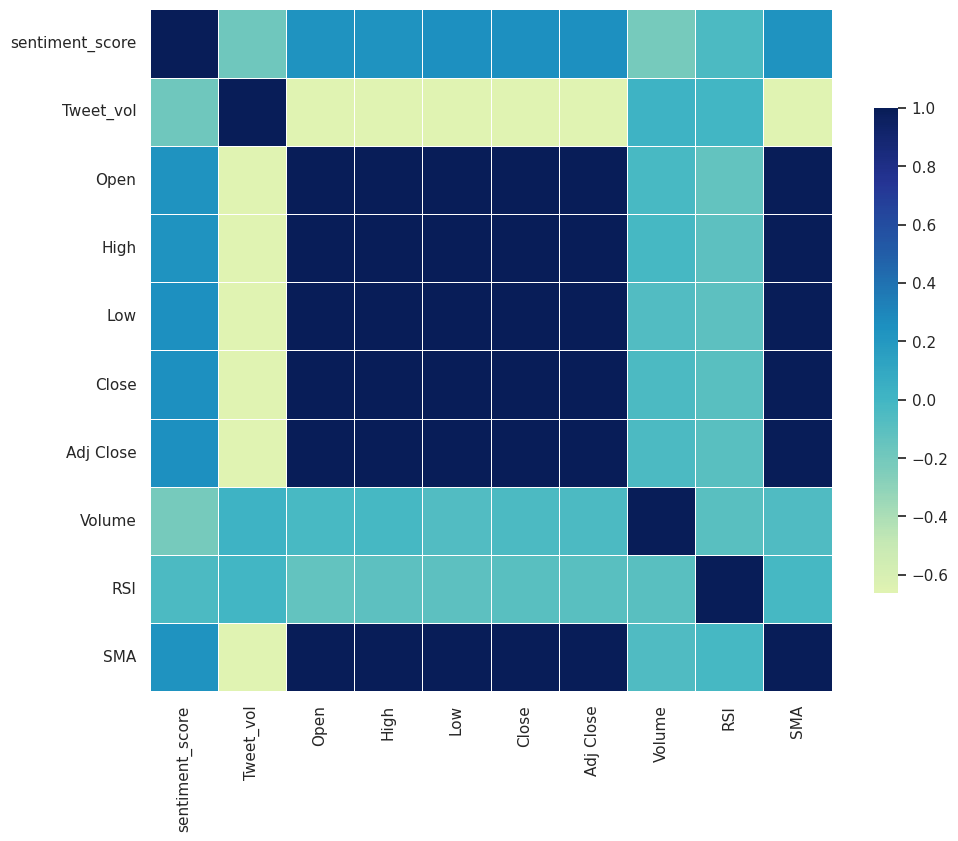

In [ ]:
import matplotlib.pyplot as plt
sns.set(style="white")
f, ax = plt.subplots(figsize=(11, 9))

ax =sns.heatmap(cor, cmap="YlGnBu", vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .7})
plt.show()

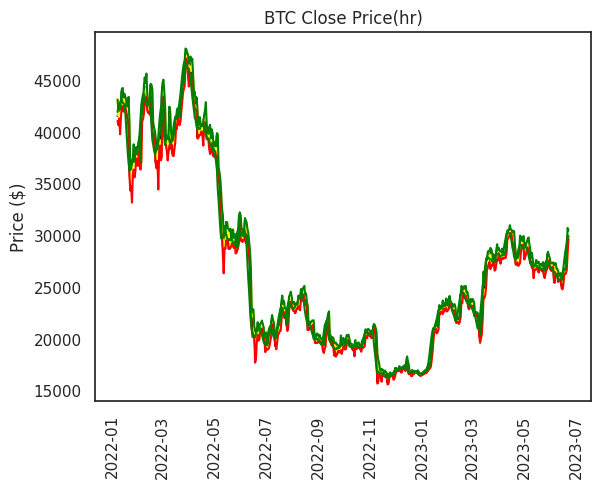

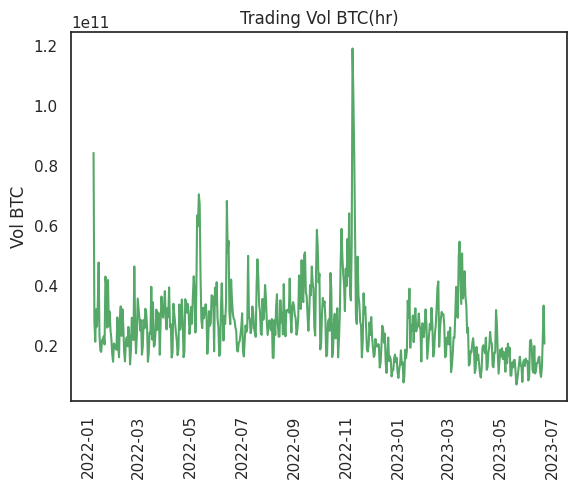

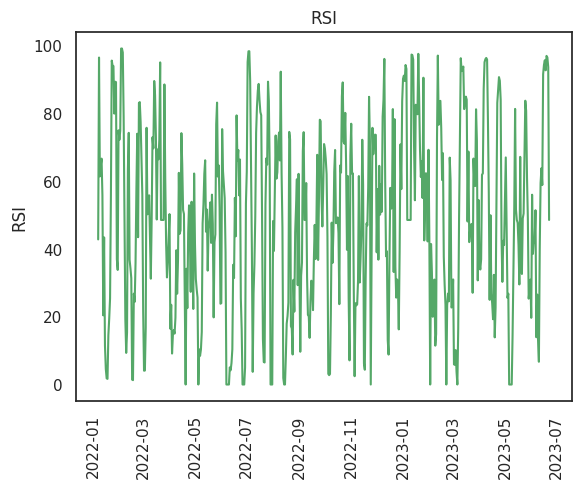

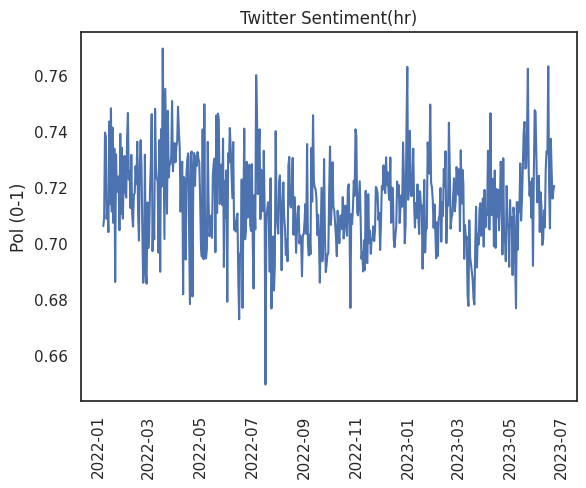

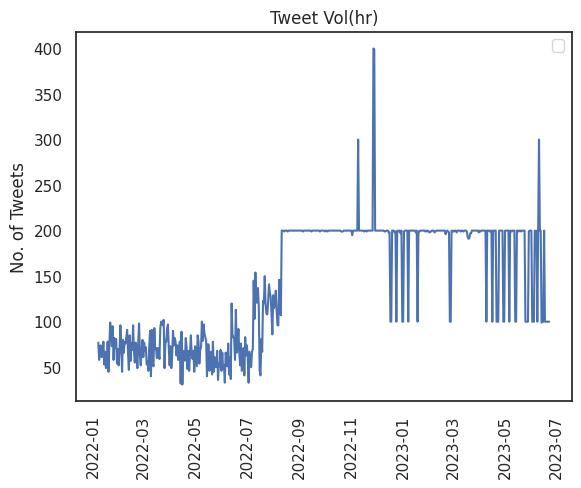

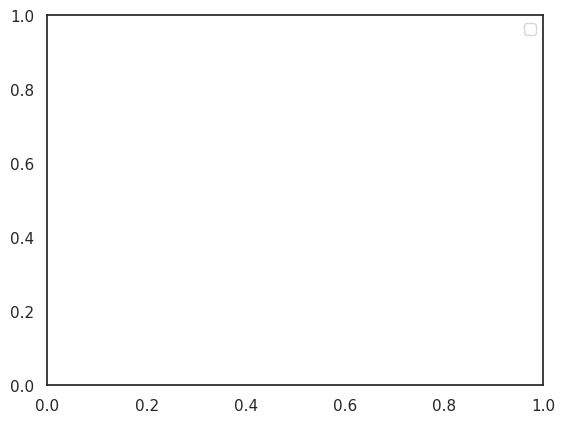

In [ ]:
plt.plot(Final_df.index, Final_df['Close'], 'black')
plt.plot(Final_df.index, Final_df['Open'], 'yellow')
plt.plot(Final_df.index, Final_df['Low'], 'red')
plt.plot(Final_df.index, Final_df['High'], 'green')
plt.plot(Final_df.index, Final_df['SMA'], 'green')
plt.title('BTC Close Price(hr)')
plt.xticks(rotation='vertical')
plt.ylabel('Price ($)');
plt.show();

plt.plot(Final_df.index, Final_df['Volume'], 'g')
plt.title('Trading Vol BTC(hr)')
plt.xticks(rotation='vertical')
plt.ylabel('Vol BTC');
plt.show();

plt.plot(Final_df.index, Final_df['RSI'], 'g')
plt.title('RSI')
plt.xticks(rotation='vertical')
plt.ylabel('RSI');
plt.show();

plt.plot(Final_df.index, Final_df['sentiment_score'], 'b')
plt.xticks(rotation='vertical')
plt.title('Twitter Sentiment(hr)')
plt.ylabel('Pol (0-1)');
plt.show();
plt.legend()

plt.plot(Final_df.index, Final_df['Tweet_vol'], 'b')
plt.xticks(rotation='vertical')
plt.title('Tweet Vol(hr)')
plt.ylabel('No. of Tweets');
plt.show();
plt.legend()

#LSTM

In [ ]:
df = Final_df.copy()
df.head()

,sentiment_score,Tweet_vol,Open,High,Low,Close,Adj Close,Volume,RSI,SMA
2022-01-07,0.706142,77.0,43153.570313,43153.570313,41077.445313,41557.902344,41557.902344,8.419661e+10,42.82,41952.11
2022-01-08,0.708978,58.0,41561.464844,42228.941406,40672.277344,41733.941406,41733.941406,2.806636e+10,96.49,42430.35
2022-01-09,0.739537,73.0,41734.726563,42663.949219,41338.160156,41911.601563,41911.601563,2.129438e+10,61.42,42601.88
2022-01-10,0.738161,74.0,41910.230469,42199.484375,39796.570313,41821.261719,41821.261719,3.210423e+10,64.55,42839.50
2022-01-11,0.708726,61.0,41819.507813,43001.156250,41407.753906,42735.855469,42735.855469,2.632765e+10,66.66,43110.73


In [ ]:
df = df.drop(['Open', 'High', 'Low', 'Adj Close'], axis=1)

In [ ]:
df.head()

,sentiment_score,Tweet_vol,Close,Volume,RSI,SMA
2022-01-07,0.706142,77.0,41557.902344,8.419661e+10,42.82,41952.11
2022-01-08,0.708978,58.0,41733.941406,2.806636e+10,96.49,42430.35
2022-01-09,0.739537,73.0,41911.601563,2.129438e+10,61.42,42601.88
2022-01-10,0.738161,74.0,41821.261719,3.210423e+10,64.55,42839.50
2022-01-11,0.708726,61.0,42735.855469,2.632765e+10,66.66,43110.73


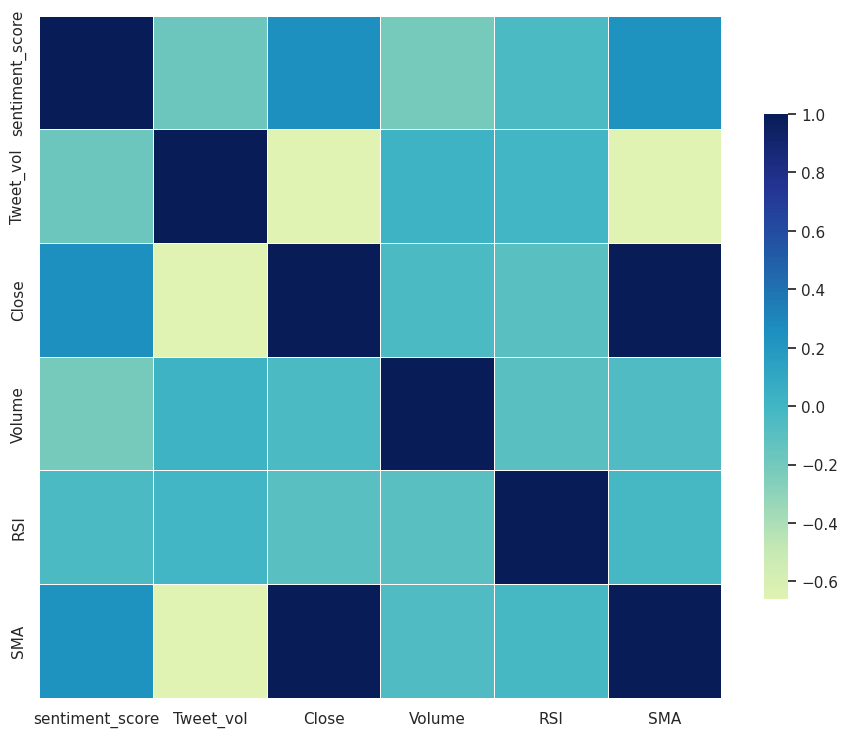

In [ ]:
cor = df.corr()
import matplotlib.pyplot as plt
sns.set(style="white")
f, ax = plt.subplots(figsize=(11, 9))

ax =sns.heatmap(cor, cmap="YlGnBu", vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .7})
plt.show()

In [ ]:
##LSTM MODEL
from math import sqrt
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

from pandas import read_csv
from pandas import DataFrame
from pandas import concat

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
values = df.values
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
df = df[['Close', 'sentiment_score','Tweet_vol','Volume','SMA','RSI']]
df.head()

,Close,sentiment_score,Tweet_vol,Volume,SMA,RSI
2022-01-07,41557.902344,0.706142,77.0,8.419661e+10,41952.11,42.82
2022-01-08,41733.941406,0.708978,58.0,2.806636e+10,42430.35,96.49
2022-01-09,41911.601563,0.739537,73.0,2.129438e+10,42601.88,61.42
2022-01-10,41821.261719,0.738161,74.0,3.210423e+10,42839.50,64.55
2022-01-11,42735.855469,0.708726,61.0,2.632765e+10,43110.73,66.66


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df.values)

In [ ]:
n_hours = 3 #adding 3 hours lags creating number of observations
n_features = 7 #Features in the dataset.
n_obs = n_hours*n_features

In [ ]:
reframed = series_to_supervised(scaled, n_hours, 1)
reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),...,var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t)
3,0.813506,0.471425,0.124661,0.689177,0.840984,0.431827,0.819063,0.495034,0.073171,0.187779,...,0.113821,0.127287,0.862283,0.619403,0.821820,0.737985,0.116531,0.223849,0.870072,0.650968
4,0.819063,0.495034,0.073171,0.187779,0.856660,0.973074,0.824672,0.749443,0.113821,0.127287,...,0.116531,0.223849,0.870072,0.650968,0.850691,0.492932,0.081301,0.172248,0.878963,0.672247
5,0.824672,0.749443,0.113821,0.127287,0.862283,0.619403,0.821820,0.737985,0.116531,0.223849,...,0.081301,0.172248,0.878963,0.672247,0.888990,0.542928,0.094851,0.236316,0.881442,0.563433
6,0.821820,0.737985,0.116531,0.223849,0.870072,0.650968,0.850691,0.492932,0.081301,0.172248,...,0.094851,0.236316,0.881442,0.563433,0.846136,0.453461,0.127371,0.363083,0.870306,0.205829
7,0.850691,0.492932,0.081301,0.172248,0.878963,0.672247,0.888990,0.542928,0.094851,0.236316,...,0.127371,0.363083,0.870306,0.205829,0.862177,0.782807,0.059621,0.147681,0.868890,0.437777


In [ ]:
reframed.values

array([[0.81350638, 0.47142484, 0.12466125, ..., 0.22384876, 0.87007241,
        0.65096813],
       [0.81906344, 0.49503411, 0.07317073, ..., 0.17224796, 0.87896336,
        0.67224687],
       [0.82467168, 0.74944281, 0.11382114, ..., 0.23631626, 0.88144154,
        0.56343284],
       ...,
       [0.3385075 , 0.46455604, 0.18699187, ..., 0.13548262, 0.43025703,
        0.97327551],
       [0.33300019, 0.73126159, 0.18699187, ..., 0.23494796, 0.44820185,
        0.94453409],
       [0.34925151, 0.63505657, 0.18699187, ..., 0.12155915, 0.44631666,
        0.48973667]])

In [ ]:
values = reframed.values
n_train_hours = 200
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train.shape

(200, 24)

In [ ]:
# split into input and outputs
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(200, 3, 7) (200,) (329, 3, 7) (329,)


In [ ]:
# design network
model = Sequential()
model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=6, validation_data=(test_X, test_y), verbose=2, shuffle=False,validation_split=0.2)
# plot history

Epoch 1/50
34/34 - 2s - 57ms/step - loss: 0.4419 - val_loss: 0.4164
Epoch 2/50
34/34 - 0s - 5ms/step - loss: 0.3161 - val_loss: 0.3140
Epoch 3/50
34/34 - 0s - 9ms/step - loss: 0.2660 - val_loss: 0.2674
Epoch 4/50
34/34 - 0s - 5ms/step - loss: 0.2532 - val_loss: 0.2533
Epoch 5/50
34/34 - 0s - 8ms/step - loss: 0.2496 - val_loss: 0.2445
Epoch 6/50
34/34 - 0s - 8ms/step - loss: 0.2471 - val_loss: 0.2396
Epoch 7/50
34/34 - 0s - 6ms/step - loss: 0.2446 - val_loss: 0.2368
Epoch 8/50
34/34 - 0s - 11ms/step - loss: 0.2421 - val_loss: 0.2350
Epoch 9/50
34/34 - 0s - 7ms/step - loss: 0.2392 - val_loss: 0.2321
Epoch 10/50
34/34 - 0s - 6ms/step - loss: 0.2367 - val_loss: 0.2298
Epoch 11/50
34/34 - 0s - 5ms/step - loss: 0.2343 - val_loss: 0.2281
Epoch 12/50
34/34 - 0s - 5ms/step - loss: 0.2316 - val_loss: 0.2256
Epoch 13/50
34/34 - 0s - 9ms/step - loss: 0.2289 - val_loss: 0.2231
Epoch 14/50
34/34 - 0s - 9ms/step - loss: 0.2265 - val_loss: 0.2209
Epoch 15/50
34/34 - 0s - 5ms/step - loss: 0.2238 - val_

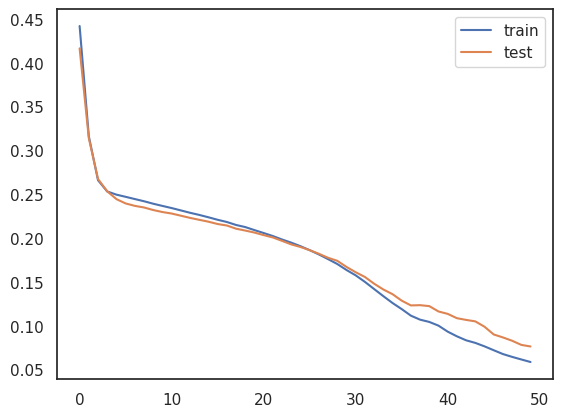

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
test_X.shape

(329, 21)

In [ ]:
# Make a prediction
yhat = model.predict(test_X)

# Reshape test_X to match model input
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))  # Ensure correct 3D shape

# Invert scaling for forecast
inv_yhat = concatenate((yhat, test_X.reshape((test_X.shape[0], -1))), axis=1)  # Flatten test_X
#inv_yhat = scaler.inverse_transform(inv_yhat)  # Inverse transform using all features
inv_yhat = inv_yhat[:, 0]  # Extract the predicted value column

# Invert scaling for actual values
test_y = test_y.reshape((len(test_y), 1))  # Reshape test_y for concatenation
inv_y = concatenate((test_y, test_X.reshape((test_X.shape[0], -1))), axis=1)  # Flatten test_X
#inv_y = scaler.inverse_transform(inv_y)  # Inverse transform using all features
inv_y = inv_y[:, 0]  # Extract the actual value column

# Calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)
rmse = sqrt(mse)
print('Test RMSE: %.3f' % rmse)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Test MSE: 0.009
Test RMSE: 0.095


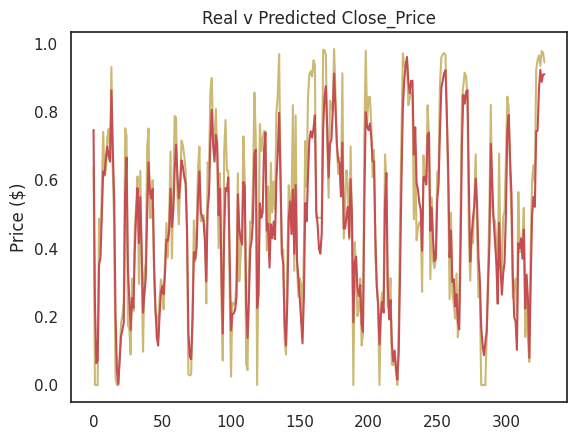

In [ ]:
plt.title('Real v Predicted Close_Price')
plt.ylabel('Price ($)')
plt.plot(inv_y, label='Real',color='y')
plt.plot(inv_yhat, label='Predicted',color='r')